# Plot Maps of ADR Arrays

## Imports

In [1]:
from obspy import UTCDateTime
from obspy.clients import fdsn
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
from obspy.clients.fdsn    import Client, RoutingClient
from obspy.signal.rotate import rotate2zne
from andbro__savefig import __savefig

import obspy.signal.array_analysis as AA
import matplotlib.pyplot  as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
def __get_inventory(config):
    coords = []
    for i, station in enumerate(config['subarray_stations']):
        inven = config['fdsn_client'].get_stations(network=config['network'][i],
                                                   station=station,
                                                   channel='BHZ',
                                                   starttime=config['starttime'],
                                                   endtime=config['starttime']+86400,
                                                   level='response'
                                                  )
        

        l_lon =  float(inven.get_coordinates('%s.%s..BHZ'%(config['network'][i],station))['longitude'])
        l_lat =  float(inven.get_coordinates('%s.%s..BHZ'%(config['network'][i],station))['latitude'])
        height = float(inven.get_coordinates('%s.%s..BHZ'%(config['network'][i],station))['elevation'])

        coords.append([l_lon,l_lat, height])

    config['coordinates'] = np.array(coords)
    return config

In [3]:
def __get_distances(config):
    
    import obspy
    
    cc_lon, cc_lat,cc_height = 0,0,0
    for c in config['coordinates']:
        cc_lon += c[0]
        cc_lat += c[1]
        cc_height += c[2]

    cc_lon /= len(config['coordinates'])
    cc_lat /= len(config['coordinates'])
    cc_height /= len(config['coordinates'])

    config['centroid'] = [cc_lon, cc_lat, cc_height]
    
    dists = []
    for lon,lat,height in config['coordinates']:    
        dist_x, dist_y = obspy.signal.util.util_geo_km(cc_lon, cc_lat, lon, lat)
        dists.append([dist_x*1000,dist_y*1000, height-cc_height])  #convert unit from km to m

    config['distances'] = np.array(dists)
    return config

In [4]:
def __get_aperture(config, reference_station=None):
    
    from numpy import argmax, array, sqrt
    import obspy 
    
    for n, sta in enumerate(config['subarray_stations']):
        if sta == reference_station:
            ref_lon, ref_lat, ref_height = config['coordinates'][n][0], config['coordinates'][n][1], config['coordinates'][n][2]
        
    dists = []
    for lon,lat,height in config['coordinates']:    
        dist_x, dist_y = obspy.signal.util.util_geo_km(ref_lon, ref_lat, lon, lat)
        dists.append(sqrt((dist_x*1000)**2+(dist_y*1000)**2))  #convert unit from km to m
        
        
    aperture = max(abs(array(dists)))
    idx = argmax(abs(array(dists)))
    
    connection = (ref_lon, ref_lat, config['coordinates'][idx][0], config['coordinates'][idx][1])
    print(f" -> Aperture of Array: {round(aperture,2)} m")
    return aperture, connection

## GRF ARRAY

In [5]:
## generate configuration object
config1 = {}

## specify client
config1['fdsn_client'] = Client('BGR')

config1['array_code'] = "GRF"


#starttime for data process
config1['starttime'] = UTCDateTime("2019-07-01T00:00")

#PFO array informatio
config1['network'] = ['GR','GR','GR','GR','GR','GR','GR','GR','GR','GR','GR','GR','GR']
config1['array_stations'] = ['GRA1','GRA2','GRA3','GRA4','GRB1','GRB2','GRB3','GRB4','GRB5','GRC1','GRC2','GRC3','GRC4']


# config1['subarray_mask'] = [0,1,2,3,4,5,6,7,8,9,10,11,12] # all
# config1['subarray_mask'] = [0,2,4,6,8,10,12] # random
# config1['subarray_mask'] = [0,1,2,3] # only A
# config1['subarray_mask'] = [4,5,6,7,8] # only B
# config1['subarray_mask'] = [9,10,11,12] # only C
# config1['subarray_mask'] = [0,1,2,3,4,5,6,7,8] #  A & B 
config1['subarray_mask'] = [8,9,10,11,12] # optimal


## adjust for selected subarray
config1['subarray_stations'] = [config1['array_stations'][j] for j in config1['subarray_mask']]
config1['network'] = [config1['network'][j] for j in config1['subarray_mask']]

## reference stations for computation of aperture
config1['reference_station'] = "GRC1"

## GRF ARRAY
# config1['label_adjustments'] = {"GRA1": [0, 1.5e-2],"GRA2": [0, 1.5e-2],"GRA3": [0, 1.5e-2],"GRA4": [0, 1.5e-2],
#                                "GRB1": [-3e-2, 2e-2],"GRB2": [0, 1.5e-2],"GRB3": [-3e-2, 1.5e-2],"GRB4": [0, 1.5e-2],"GRB5": [0, 1.5e-2],
#                                "GRC1": [0, 1.5e-2],"GRC2": [0, 1.5e-2],"GRC3": [0, 1.5e-2],"GRC4": [0, 1.5e-2]}
config1['label_adjustments'] = {"GRA1": [0, 1e-2],"GRA2": [0, 1e-2],"GRA3": [0, 1e-2],"GRA4": [0, 1e-2],
                               "GRB1": [0, 1e-2],"GRB2": [0, 1e-2],"GRB3": [0, 1e-2],"GRB4": [0, 1e-2],"GRB5": [-2e-2, -1.5e-2],
                               "GRC1": [0, 1e-2],"GRC2": [1e-2, 0e-2],"GRC3": [0, 1e-2],"GRC4": [0, 1e-2]}

config1 = __get_inventory(config1)
config1 = __get_distances(config1)

## ROMY ARRAY

In [6]:
## generate configuration object
config2 = {}

## specify client
config2['fdsn_client'] = Client(base_url="http://jane", timeout=300)
# config2['fdsn_client'] = RoutingClient("lmu")
# config2['fdsn_client'] = RoutingClient("eida-routing")


#starttime for data process
config2['starttime'] = UTCDateTime("2022-01-01T00:00")

config2['array_code'] = "RMY"

#PFO array information
config2['network'] = ['GR','BW','BW','BW','BW','BW','BW','BW','BW']
config2['array_stations'] = ['FUR','FFB1','FFB2','FFB3','GELB','GRMB','TON','ALFT','BIB']

config2['subarray_mask'] = [0,1,2,3,4,5,6,7,8] # all
# config2['subarray_mask'] = [0,1,2,3] # only inner
# config2['subarray_mask'] = [0,4,5,6,7,8] # optimal


## adjust for selected subarray
config2['subarray_stations'] = [config2['array_stations'][j] for j in config2['subarray_mask']]
config2['network'] = [config2['network'][j] for j in config2['subarray_mask']]

## reference stations for computation of aperture
config2['reference_station'] = "FUR"

## ROMY ARRAY
config2['label_adjustments'] = {"BIB": [0, 1e-3],"TON": [-1.5e-3, -2e-3],"GELB": [0, 1e-3],
                               "GRMB": [1e-3, 0.5e-3],"ALFT": [0, 1e-3],"FFB1": [-5e-3, -1e-3],
                               "FFB2": [-2e-3, 1e-3],"FFB3": [0, 1e-3],"FUR": [1e-3, -2e-3]}

config2 = __get_inventory(config2)
config2 = __get_distances(config2)

## PFO ARRAY

In [7]:
## generate configuration object
config3 = {}

## specify client
config3['fdsn_client'] = Client('IRIS')

#starttime for data process
config3['starttime'] = UTCDateTime("2019-11-02T00:00:00")

# config3['save_path'] = "/home/andbro/kilauea-data/LNM/data/PFO/adr/"
config3['save_path'] = "/export/data/LNM/data/PFO/adr/"

config3['array_code'] = "PFO"

#PFO array information
config3['network'] = ['PY','PY','PY','PY','PY','PY','PY','PY','PY','PY','PY','PY','PY']
config3['array_stations'] = ['BPH01','BPH02','BPH03','BPH04','BPH05','BPH06','BPH07','BPH08','BPH09','BPH10','BPH11','BPH12','BPH13']
config3['misorientations'] =  [0. ,-1.375 ,0.25 ,0.125 ,-0.6875 ,-0.625 ,-1.9375 ,0.375  ,-6.5625 ,0.3125 ,-1.125 ,-2.5625 ,0.1875]

config3['array_station'] =[]
config3['misorientation'] =[]

# config3['subarray_mask'] = [0,1,2,3,4,5,6,7,8,9,10,11,12] #all
# config3['subarray_mask'] = [0,5,8,9,10,11,12] #optimal
config3['subarray_mask'] = [0,1,2,3] #inner

config3['subarray'] = np.arange(len(config3['array_stations']))

config3['subarray_stations'] = [config3['array_stations'][i] for i in config3['subarray_mask']]
config3['network'] = [config3['network'][j] for j in config3['subarray_mask']]
config3['subarray_misorientation'] = [config3['misorientations'][i] for i in config3['subarray']]

config3['samples'] = 86400*20

#parameter for array-derivation
config3['prefilt'] = (0.001, 0.01, 5, 10)
config3['freq1'] = 0.014   #0.014 for Spudich    and  0.073 for Langston
config3['freq2'] = 1.5
config3['bpf'] = True
config3['channel_resp'] = 'BHZ'
config3['debug'] = True

# adr parameters
config3['vp'] = 6264. #1700
config3['vs'] = 3751. #1000
config3['sigmau'] = 0.0001

## reference stations for computation of aperture
# config3['reference_station'] = "BPH11"
config3['reference_station'] = "BPH01"


## PFO ARRAY
config3['label_adjustments'] = {"BPH01": [0, 2e-4],"BPH02": [0, 2e-4],"BPH03": [0, -4.3e-4],
                               "BPH04": [-1.3e-3, -4.1e-4],"BPH05": [0, 1.3e-4],"BPH06": [0, 2e-4],
                               "BPH07": [0, 1.5e-4],"BPH08": [0, 1.5e-4],"BPH09": [0, -4.3e-4],
                               "BPH10": [-5e-4, 2e-4],"BPH11": [-8e-4, 2e-4],
                               "BPH12": [3e-4, 1.2e-4],"BPH13": [-2e-4, 2e-4]}

config3 = __get_inventory(config3)
config3 = __get_distances(config3)

## ALl Maps

In [8]:
def __makeplot_maps(configs):

    
    fig, ax = plt.subplots(2,2, figsize=(12,12))
    
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    
    font = 14 
    
    for ii, config in enumerate(configs):

        if ii == 0: 
            k,l = 0,0
        if ii == 1:
            k,l = 0,1
        if ii == 2:
            k,l = 1,0
        
        aper, connect = __get_aperture(config, reference_station=config['reference_station'])


        for n, (c, sta) in enumerate(zip(config['coordinates'], config['subarray_stations'])):

            if config['array_code'] == "PFO":
                if n in [0,5,8,9,10,11,12]:
                    ax[k,l].scatter(c[0], c[1], c='g', marker="^", s=80, zorder=2)
                    ax[k,l].scatter(-116.4605, 33.61, c='g', marker="^", s=0, zorder=2)
                    ax[k,l].scatter(-116.451, 33.61, c='g', marker="^", s=0, zorder=2)

                else:
                    ax[k,l].scatter(c[0], c[1], c='r', marker="^", s=80, zorder=2)
            else:
                ax[k,l].scatter(c[0], c[1], c='r', marker="^", s=80, zorder=2)

            try:
                x, y = config['label_adjustments'][sta]
                ax[k,l].text(c[0]+x, c[1]+y, sta, zorder=2)
            except:
                print(f"{config['array_stations'][n]} has no label..")

        ax[k,l].scatter(config['centroid'][0], config['centroid'][1], s=100, marker="+", c='k',zorder=2)

        ax[k,l].set_title(f"{config['array_code']} Array Stations - Aperture: {int(round(aper,0))} m")
        ax[k,l].ticklabel_format(useOffset=False, style='plain')
        ax[k,l].grid(alpha=0.5, zorder=0)

    
        ## draw connection
        ax[k,l].plot([connect[0], connect[2]], [connect[1], connect[3]], ls=":", zorder=1, color='k')
    
    ## panel labels
    ax[0,0].text(.01, .99, 'a)', ha='left', va='top', transform=ax[0,0].transAxes, fontsize=font+2)
    ax[0,1].text(.01, .99, 'b)', ha='left', va='top', transform=ax[0,1].transAxes, fontsize=font+2)
    ax[1,0].text(.01, .99, 'c)', ha='left', va='top', transform=ax[1,0].transAxes, fontsize=font+2)
                
    ax[1,1].axis('off')

    ax[0,1].set_xlabel("Longitude (°)", fontsize=font)
    ax[1,0].set_xlabel("Longitude (°)", fontsize=font)
    ax[1,1].set_xlabel("Longitude (°)", fontsize=font)
    ax[0,0].set_ylabel("Latitude (°)", fontsize=font)
    ax[1,0].set_ylabel("Latitude (°)", fontsize=font)


    ax[1,0].locator_params(axis="x", nbins=5)

    plt.show();
    return fig

 -> Aperture of Array: 88.84 m
 -> Aperture of Array: 2633.99 m
 -> Aperture of Array: 17850.8 m


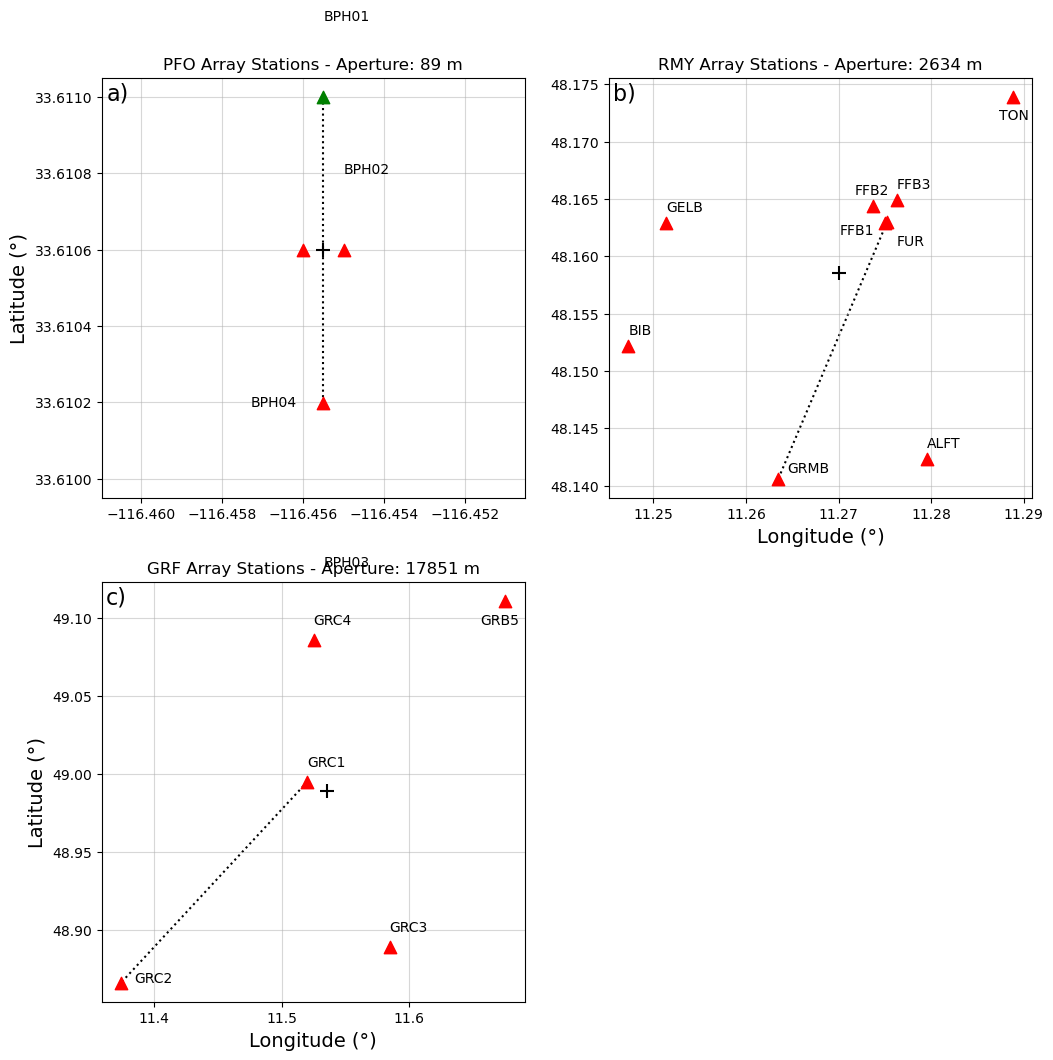

In [9]:
fig = __makeplot_maps([config3, config2, config1]);

In [10]:
# __savefig(fig, outpath="/export/data/LNM/figures_final/", outname="maps_ADR_arrays_final", mode="png", dpi=300)

In [11]:
# def __makeplot_maps(configs):

    
#     fig, ax = plt.subplots(2,2, figsize=(12,12))
    
#     plt.subplots_adjust(hspace=0.2, wspace=0.2)
    
#     font = 14 
    
#     for ii, config in enumerate(configs):

#         if ii == 0: 
#             k,l = 1,1
#         if ii == 1:
#             k,l = 0,1
#         if ii == 2:
#             k,l = 1,0
        
#         aper, connect = __get_aperture(config, reference_station=config['reference_station'])


#         for n, (c, sta) in enumerate(zip(config['coordinates'], config['subarray_stations'])):

#             if config['array_code'] == "PFO":
#                 if n in [0,5,8,9,10,11,12]:
#                     ax[k,l].scatter(c[0], c[1], c='g', marker="^", s=80, zorder=2)
#                     ax[k,l].scatter(-116.4605, 33.61, c='g', marker="^", s=0, zorder=2)
#                     ax[k,l].scatter(-116.451, 33.61, c='g', marker="^", s=0, zorder=2)

#                 else:
#                     ax[k,l].scatter(c[0], c[1], c='r', marker="^", s=80, zorder=2)
#             else:
#                 ax[k,l].scatter(c[0], c[1], c='r', marker="^", s=80, zorder=2)

#             try:
#                 x, y = config['label_adjustments'][sta]
#                 ax[k,l].text(c[0]+x, c[1]+y, sta, zorder=2)
#             except:
#                 print(f"{config['array_stations'][n]} has no label..")

#         ax[k,l].scatter(config['centroid'][0], config['centroid'][1], s=100, marker="+", c='k',zorder=2)

#         ax[k,l].set_title(f"{config['array_code']} Array Stations - Aperture: {int(round(aper,0))} m")
#         ax[k,l].ticklabel_format(useOffset=False, style='plain')
#         ax[k,l].grid(alpha=0.5, zorder=0)

    
#         ## draw connection
#         ax[k,l].plot([connect[0], connect[2]], [connect[1], connect[3]], ls=":", zorder=1, color='k')
    
#     ## panel labels
#     ax[0,1].text(.01, .99, 'a)', ha='left', va='top', transform=ax[0,1].transAxes, fontsize=font+2)
#     ax[1,1].text(.01, .99, 'b)', ha='left', va='top', transform=ax[1,1].transAxes, fontsize=font+2)
#     ax[1,0].text(.01, .99, 'c)', ha='left', va='top', transform=ax[1,0].transAxes, fontsize=font+2)
                
#     ax[0,0].axis('off')

# #     ax[0,1].set_xlabel("Longitude (°)", fontsize=font)
#     ax[1,0].set_xlabel("Longitude (°)", fontsize=font)
#     ax[1,1].set_xlabel("Longitude (°)", fontsize=font)
#     ax[0,1].set_ylabel("Latitude (°)", fontsize=font)
#     ax[1,0].set_ylabel("Latitude (°)", fontsize=font)


#     ax[1,0].locator_params(axis="x", nbins=5)

#     plt.show();
#     return fig

In [12]:
# fig = __makeplot_maps([config3, config2, config1]);

# __savefig(fig, outpath="/export/data/LNM/figures_final/", outname="maps_ADR_arrays_final_slides", mode="png", dpi=300)

## Single Map

In [13]:
# def __plot_stations(config1):

#     aper = __get_aperture(config, reference_station=config['reference_station'])
    
#     fig, ax = plt.subplots(1,1, figsize=(7,7))
    
#     font = 14
    
#     for n, (c, sta) in enumerate(zip(config['coordinates'], config['subarray_stations'])):

        
#         if config['array_code'] == "PFO":
#             if n in [0,5,8,9,10,11,12]:
#                 ax.scatter(c[0], c[1], c='g', marker="^", s=80, zorder=2)
#             else:
#                 ax.scatter(c[0], c[1], c='r', marker="^", s=80, zorder=2)
#         else:
#             ax.scatter(c[0], c[1], c='r', marker="^", s=80, zorder=2)
        
#         try:
#             x, y = config['label_adjustments'][sta]
#             ax.text(c[0]+x, c[1]+y, sta, zorder=2)
#         except:
#             print(f"{config['array_stations'][n]} has no label..")
                      
#     ax.scatter(config['centroid'][0], config['centroid'][1], s=100, marker="+", c='k',zorder=2)

#     ax.set_title(f"{config['array_code']} Array stations - Aperture: {int(round(aper,0))} m")
    
#     ax.set_xlabel("Longitude (°)", fontsize=font)
#     ax.set_ylabel("Latitude (°)", fontsize=font)
    
#     ax.grid(alpha=0.5, zorder=0)
    
#     plt.show();
#     return fig

In [14]:
# __plot_stations(config1);

In [15]:
# __get_aperture(config, reference_station=config['reference_station']);

In [16]:
0.03 * 3800 /730, 0.25*3800 / 730

(0.15616438356164383, 1.3013698630136987)